In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [15]:
test = pd.read_csv('Data/MNIST/mnist_test.csv')
train = pd.read_csv('Data/MNIST/mnist_train.csv')

In [16]:
test.isna().sum().sum(), train.isna().sum().sum()

(0, 0)

In [17]:
train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


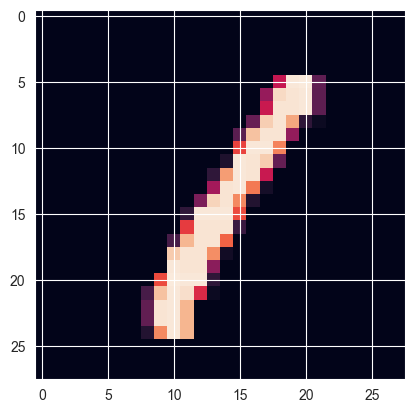

In [18]:
plt.imshow(train.iloc[3, 1:].to_numpy().reshape(28, 28))

In [19]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.pca = PCA(n_components=20)
        self.kmeans = KMeans(n_clusters=10)
        self.scaler1 = StandardScaler()
        self.scaler2 = StandardScaler()

    def fit(self, X, y=None):
        pca_pred = self.pca.fit_transform(X)
        # kmeans_pred = self.kmeans.fit_transform(pca_pred)
        # self.scaler1.fit(kmeans_pred)
        self.scaler2.fit(pca_pred)
        return self

    def transform(self, X):
        # return np.concatenate([self.scaler2.transform(self.pca.transform(X)),
        #                        self.scaler1.transform(self.kmeans.transform(self.pca.transform(X)))], axis=1) Неудачно
        return self.scaler2.transform(self.pca.transform(X))

    @staticmethod
    def get_feature_names_out():
        return ['c1', 'c2', 'c3', 'c4', 'c5',
                'c6', 'c7', 'c8', 'c9', 'c10',
                'c11', 'c12', 'c13', 'c14', 'c15',
                'c16', 'c17', 'c18', 'c19', 'c20']

In [20]:
X_train, y_train = train.drop(['label'], axis=1), train['label']
X_test, y_test = test.drop(['label'], axis=1), test['label']

In [21]:
a = CustomTransformer().fit_transform(X_train)

In [22]:
from sklearn.manifold import TSNE

counter = 10000
data = pd.DataFrame(TSNE(n_components=2).fit_transform(a[:counter, :]))
labels = y_train[:counter]

<Axes: xlabel='0', ylabel='1'>

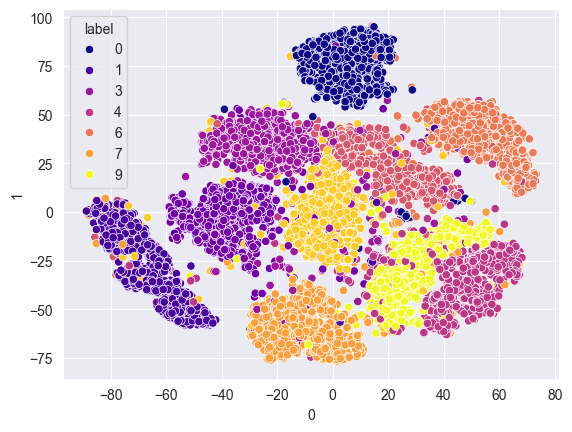

In [23]:
import seaborn as sns

sns.scatterplot(data=data, x=0, y=1, hue=labels, palette='plasma')

In [24]:
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report

catboost_pipe = Pipeline(steps=[('col_transform', CustomTransformer()),
                                ('catboost', CatBoostClassifier())])

catboost_pipe.fit(X_train, y_train)
print(classification_report(y_test, catboost_pipe.predict(X_test)))

Learning rate set to 0.097501
0:	learn: 1.9777371	total: 160ms	remaining: 2m 40s
1:	learn: 1.7863769	total: 287ms	remaining: 2m 23s
2:	learn: 1.6469183	total: 394ms	remaining: 2m 10s
3:	learn: 1.5383894	total: 501ms	remaining: 2m 4s
4:	learn: 1.4479919	total: 608ms	remaining: 2m
5:	learn: 1.3622681	total: 717ms	remaining: 1m 58s
6:	learn: 1.2888081	total: 825ms	remaining: 1m 57s
7:	learn: 1.2250849	total: 932ms	remaining: 1m 55s
8:	learn: 1.1714422	total: 1.04s	remaining: 1m 54s
9:	learn: 1.1221939	total: 1.15s	remaining: 1m 53s
10:	learn: 1.0809855	total: 1.26s	remaining: 1m 53s
11:	learn: 1.0448295	total: 1.37s	remaining: 1m 52s
12:	learn: 1.0147168	total: 1.47s	remaining: 1m 51s
13:	learn: 0.9826805	total: 1.58s	remaining: 1m 51s
14:	learn: 0.9536876	total: 1.69s	remaining: 1m 51s
15:	learn: 0.9215128	total: 1.8s	remaining: 1m 50s
16:	learn: 0.8998063	total: 1.91s	remaining: 1m 50s
17:	learn: 0.8708987	total: 2.03s	remaining: 1m 50s
18:	learn: 0.8462603	total: 2.15s	remaining: 1m 51

In [25]:
def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    plt.figure(figsize=(10, 8))

    palette = sns.color_palette('plasma', len(fi_df))
    sns.barplot(x=fi_df['feature_importance'],
                y=fi_df['feature_names'],
                palette=palette,
                hue=fi_df['feature_names'],
                legend=False)

    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')


plot_feature_importance(
    catboost_pipe.named_steps['catboost'].feature_importances_,
    CustomTransformer.get_feature_names_out(),
    'Catboost')

NameError: name 'np' is not defined

In [ ]:
predictions = catboost_pipe.predict(X_test).reshape(-1, )
mask = (y_test == predictions)
error_idx = (y_test == predictions).loc[~mask].index.to_numpy()

In [ ]:
np.random.shuffle(error_idx)
fig, ax = plt.subplots(3, 3)
for i, idx in enumerate(error_idx[:9]):
    ax[i // 3, i % 3].title.set_text(f'Prediction - {predictions[idx]}')
    ax[i // 3, i % 3].imshow(X_test.iloc[idx, :].to_numpy().reshape(28, 28), cmap='gray')
    ax[i // 3, i % 3].set_axis_off()

plt.tight_layout()

In [ ]:
X_noise_train = X_train + 3.5 * np.random.randn(X_train.shape[0] * X_train.shape[1]).reshape(-1, 784)

In [ ]:
fig, ax = plt.subplots(1, 2)

i = np.random.randint(0, X_train.shape[0])

ax[0].title.set_text('Train')
ax[0].imshow(X_train.iloc[i, :].to_numpy().reshape(28, 28), cmap='gray')
ax[0].set_axis_off()

ax[1].title.set_text('Noise')
ax[1].imshow(X_noise_train.iloc[i, :].to_numpy().reshape(28, 28), cmap='gray')
ax[1].set_axis_off()

In [ ]:
noise_pipe = Pipeline(steps=[('col_transform', CustomTransformer()),
                             ('catboost', CatBoostClassifier())])

noise_pipe.fit(X_noise_train, y_train)
print(classification_report(y_test, noise_pipe.predict(X_test)))

In [ ]:
predictions = noise_pipe.predict(X_test).reshape(-1, )
mask = (y_test == predictions)
error_idx = (y_test == predictions).loc[~mask].index.to_numpy()

np.random.shuffle(error_idx)
fig, ax = plt.subplots(3, 3)
for i, idx in enumerate(error_idx[:9]):
    ax[i // 3, i % 3].title.set_text(f'Prediction - {predictions[idx]}')
    ax[i // 3, i % 3].imshow(X_noise_train.iloc[idx, :].to_numpy().reshape(28, 28), cmap='gray')
    ax[i // 3, i % 3].set_axis_off()

plt.tight_layout()

In [ ]:
from xgboost import XGBClassifier

xgb_pipe = Pipeline(steps=[('col_transform', CustomTransformer()),
                           ('xgboost', XGBClassifier())])

xgb_pipe.fit(X_train, y_train)
print(classification_report(y_test, xgb_pipe.predict(X_test)))

# CatBoost accuracy не может подняться выше 97, пробуем KNN  

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_pipe = Pipeline(steps=[('col_transform', CustomTransformer()),
                           ('knn', KNeighborsClassifier())])

knn_pipe.fit(X_train, y_train)
print(classification_report(y_test, knn_pipe.predict(X_test)))

# В общем то же самое, надо делать нейронку

In [28]:
data = pd.read_csv('Data/MNIST/mnist_test.csv')
data.head()


,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
data.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
data.head().apply(lambda x: x[1]+1, axis=0)

label    3
1x1      1
1x2      1
1x3      1
1x4      1
        ..
28x24    1
28x25    1
28x26    1
28x27    1
28x28    1
Length: 785, dtype: int64